# 06. Deep Learning: Transformer Model

This notebook trains a Transformer-based neural network. It uses self-attention mechanisms to learn complex patterns in the feature set.

In [1]:
# Imports
import pandas as pd
import numpy as np
import pickle
import json
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, 
    precision_recall_curve, auc, brier_score_loss
)

import warnings
warnings.filterwarnings("ignore")

# Settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Load Processed Data

In [2]:
# Load data
with open('../data/processed/churn_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train_scaled'] 
y_train = data['y_train']
X_val = data['X_val_scaled']
y_val = data['y_val']
X_test = data['X_test_scaled']
y_test = data['y_test']

print(f"Train samples: {len(X_train)}")
print(f"Val samples:   {len(X_val)}")

Train samples: 265
Val samples:   67


## 2. Prepare Data for PyTorch

Reshape input from (N, Features) to (N, 1, Features) for sequence processing.

In [3]:
class ChurnDataset(Dataset):
    def __init__(self, X, y):
        # Reshape to (Batch, Sequence, Features)
        self.X = torch.FloatTensor(X.values if hasattr(X, 'values') else X).unsqueeze(1)
        self.y = torch.FloatTensor(y.values if hasattr(y, 'values') else y)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(ChurnDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(ChurnDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(ChurnDataset(X_test, y_test), batch_size=batch_size)

input_size = X_train.shape[1]
print(f"Input features: {input_size}")

Input features: 154


## 3. Define Transformer Model

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerChurnModel(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_layers, dropout):
        super(TransformerChurnModel, self).__init__()
        
        self.input_projection = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*2, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        self.fc1 = nn.Linear(d_model, 16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(16, 1)
        # Removed sigmoid for BCEWithLogitsLoss
        
    def forward(self, x):
        # Project input features to d_model dimension
        x = self.input_projection(x)
        x = self.pos_encoder(x)
        
        # Transformer encoding
        # Permute for transformer: (Seq, Batch, Feature)
        x = x.permute(1, 0, 2)
        transformer_out = self.transformer_encoder(x)
        
        # Take mean across sequence
        pooled = transformer_out.mean(dim=0)
        
        out = self.fc1(pooled)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out.squeeze() # Return logits


## 4. Train Model

In [5]:
model = TransformerChurnModel(
    input_size=input_size,
    d_model=64,
    nhead=4,
    num_layers=2,
    dropout=0.1
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training Loop
epochs = 200
best_val_loss = float('inf')
patience = 20
counter = 0

train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
        
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '../results/models/transformer/transformer_best_model.pt')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

print(" Training complete")


Starting training...
Epoch 10/200 - Train Loss: 0.6671 - Val Loss: 0.6570
Epoch 20/200 - Train Loss: 0.6528 - Val Loss: 0.6311
Epoch 30/200 - Train Loss: 0.6238 - Val Loss: 0.5965
Epoch 40/200 - Train Loss: 0.5757 - Val Loss: 0.5585
Epoch 50/200 - Train Loss: 0.5102 - Val Loss: 0.5632
Epoch 60/200 - Train Loss: 0.4893 - Val Loss: 0.5765
Early stopping at epoch 61
 Training complete


 Saved training loss plot


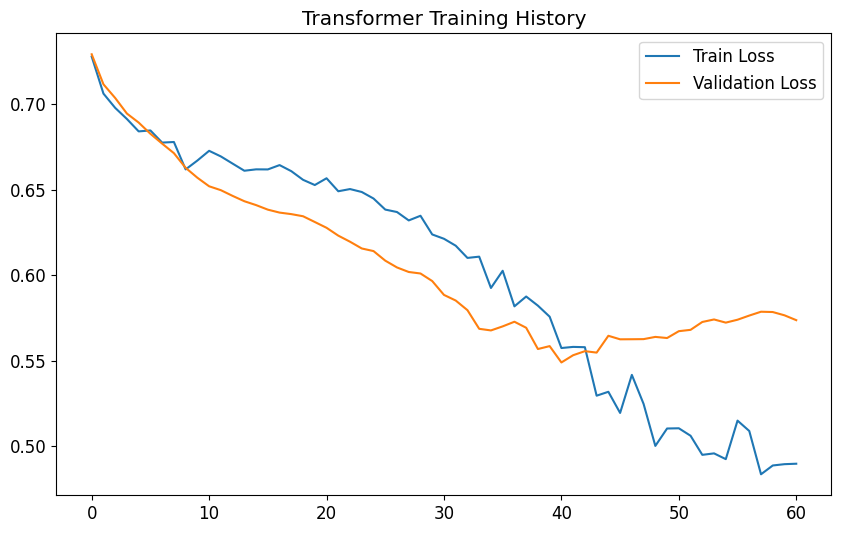

In [6]:
# Plot Loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title("Transformer Training History")

plt.savefig('../results/figures/transformer/transformer_training_loss.png')
print(' Saved training loss plot')
plt.show()

## 5. Evaluation

In [7]:
# Load Best Model
model.load_state_dict(torch.load('../results/models/transformer/transformer_best_model.pt'))
model.eval()

y_true = []
y_pred_proba = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        y_true.extend(y_batch.cpu().numpy())
        # Apply sigmoid to logits
        y_pred_proba.extend(torch.sigmoid(outputs).cpu().numpy())
        
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)
y_pred = (y_pred_proba >= 0.5).astype(int)

# Metrics
accuracy = accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_proba)

precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
pr_auc = auc(recall, precision)

brier = brier_score_loss(y_true, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"Brier Score: {brier:.4f}")


Accuracy: 0.6265
ROC-AUC: 0.6776
PR-AUC: 0.7061
Brier Score: 0.2207


## 6. Save Results

In [8]:
# Save Metrics
metrics = {
    'model': 'Transformer',
    'accuracy': float(accuracy),
    'roc_auc': float(roc_auc),
    'pr_auc': float(pr_auc),
    'brier': float(brier)
}

with open('../results/metrics/transformer/transformer_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)
print(" Metrics saved to ../results/metrics/transformer/transformer_metrics.json")

 Metrics saved to ../results/metrics/transformer/transformer_metrics.json
